In [2]:
import pandas as pd
import numpy as np
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm


In [3]:
# === File paths ===
DATA_PATH = "../../../ieee-fraud-detection/"
TRAIN_TRANS_FILE = "train_transaction.csv"
TRAIN_IDENTITY_FILE = "train_identity.csv"
TEST_TRANS_FILE = "test_transaction.csv"
TEST_IDENTITY_FILE = "test_identity.csv"

# === Load Data ===
def load_data():
    print("Loading train and test data...")

    train_transaction = pd.read_csv(os.path.join(DATA_PATH, TRAIN_TRANS_FILE))
    train_identity = pd.read_csv(os.path.join(DATA_PATH, TRAIN_IDENTITY_FILE))
    train = pd.merge(train_transaction, train_identity, how="left", on="TransactionID")

    test_transaction = pd.read_csv(os.path.join(DATA_PATH, TEST_TRANS_FILE))
    test_identity = pd.read_csv(os.path.join(DATA_PATH, TEST_IDENTITY_FILE))
    test = pd.merge(test_transaction, test_identity, how="left", on="TransactionID")

    return train, test

# Load data
train_raw, test_raw = load_data()
train_raw.shape, test_raw.shape


Loading train and test data...


((590540, 434), (506691, 433))

In [4]:
def get_column_types(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    return numerical_cols, categorical_cols


In [5]:
def iterative_impute_fast(df, columns, max_iter=5, sample_frac=0.1, verbose=True):
    df = df.copy()
    if verbose:
        print(f"\n⚡ Fast Iterative Imputation: {len(columns)} columns | Sample: {sample_frac*100:.0f}% | Estimator: DecisionTree\n")

    sample_df = df[columns].sample(frac=sample_frac, random_state=42)

    imputer = IterativeImputer(
        estimator=DecisionTreeRegressor(max_depth=5),
        max_iter=max_iter,
        random_state=42,
        verbose=0
    )

    imputer.fit(sample_df)
    df[columns] = imputer.transform(df[columns])

    print(" Fast iterative imputation complete.\n")
    return df


In [6]:
def clean_data(df, target_column='isFraud'):
    print(" Cleaning data...")
    df = df.copy()
    numerical_cols, categorical_cols = get_column_types(df)

    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

    # Calculate missing ratios
    missing_ratios = df[numerical_cols].isnull().mean()

    # Segmentation by % missing
    iter_missing = missing_ratios[missing_ratios < 0.10].index.tolist()
    mean_missing = missing_ratios[(missing_ratios >= 0.10) & (missing_ratios < 0.35)].index.tolist()
    median_missing = missing_ratios[(missing_ratios >= 0.35) & (missing_ratios <= 0.70)].index.tolist()
    high_missing = missing_ratios[missing_ratios > 0.70].index.tolist()

    print(f"Dropping {len(high_missing)} columns with >70% missing values...")
    df.drop(columns=high_missing, inplace=True)

    # Iterative Imputer for very low-missing features
    if iter_missing:
        print(f"Iteratively imputing {len(iter_missing)} columns (<10% missing)...")
        t0 = time.time()
        df = iterative_impute_fast(df, iter_missing, max_iter=5, sample_frac=0.1, verbose=True)
        print(f" Iterative imputation complete in {time.time() - t0:.2f} seconds.\n")

    # Mean Imputer for moderate-missing features
    if mean_missing:
        print(f" Applying Mean Imputer to {len(mean_missing)} columns (10–35% missing)...")
        t1 = time.time()
        mean_imp = SimpleImputer(strategy='mean')
        df[mean_missing] = mean_imp.fit_transform(df[mean_missing])
        print(f" Mean imputation complete in {time.time() - t1:.2f} seconds.\n")

    # Median Imputer for high-missing but usable features
    if median_missing:
        print(f" Applying Median Imputer to {len(median_missing)} columns (35–70% missing)...")
        t2 = time.time()
        median_imp = SimpleImputer(strategy='median')
        df[median_missing] = median_imp.fit_transform(df[median_missing])
        print(f" Median imputation complete in {time.time() - t2:.2f} seconds.\n")

    print(" Data cleaning complete.\n")
    return df


In [7]:
train_cleaned = clean_data(train_raw)
train_cleaned.shape


 Cleaning data...
Dropping 190 columns with >70% missing values...
Iteratively imputing 108 columns (<10% missing)...

⚡ Fast Iterative Imputation: 108 columns | Sample: 10% | Estimator: DecisionTree

 Fast iterative imputation complete.

 Iterative imputation complete in 81.98 seconds.

 Applying Mean Imputer to 88 columns (10–35% missing)...
 Mean imputation complete in 1.75 seconds.

 Applying Median Imputer to 16 columns (35–70% missing)...
 Median imputation complete in 1.12 seconds.

 Data cleaning complete.



(590540, 244)

In [8]:
# Separate target and features
X = train_cleaned.drop(columns=['isFraud'])
y = train_cleaned['isFraud']

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (472432, 243)
Validation shape: (118108, 243)


In [9]:
# Convert object columns to category so LightGBM can handle them
def prepare_lightgbm_data(X):
    X = X.copy()
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')
    return X

X_train = prepare_lightgbm_data(X_train)
X_val = prepare_lightgbm_data(X_val)


In [10]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [11]:
def train_lightgbm(X_train, y_train, X_val, y_val):
    print(" Training LightGBM model...")

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature='auto')

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': 0.05,
        'num_leaves': 64,
        'max_depth': -1,
        'random_state': 42
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    print(" Model training complete.\n")
    return model


In [12]:
def plot_roc_auc(model, X_val, y_val):
    print(" Generating ROC curve...")
    y_proba = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f" AUC Score: {auc_score:.4f}\n")


 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.949874	val's auc: 0.936263
[200]	train's auc: 0.969424	val's auc: 0.950495
[300]	train's auc: 0.978255	val's auc: 0.956172
[400]	train's auc: 0.984105	val's auc: 0.959781
[500]	train's auc: 0.988386	val's auc: 0.962556
[600]	train's auc: 0.991328	val's auc: 0.964972
[700]	train's auc: 0.993145	val's auc: 0.966587
[800]	train's auc: 0.99479	val's auc: 0.967761
[900]	train's auc: 0.995888	val's auc: 0.968935
[1000]	train's auc: 0.996664	val's auc: 0.969814
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.996664	val's auc: 0.969814
 Model training complete.

 Generating ROC curve...


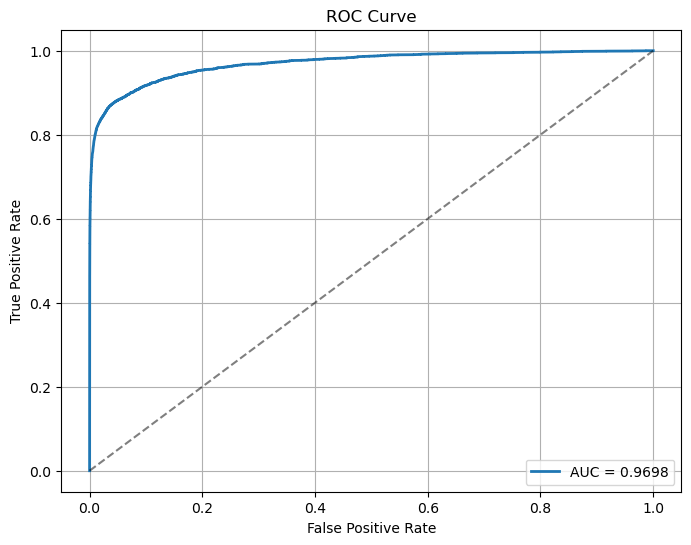

 AUC Score: 0.9698



In [13]:
# Train the model
lgb_model = train_lightgbm(X_train, y_train, X_val, y_val)

# Plot ROC & AUC
plot_roc_auc(lgb_model, X_val, y_val)


 Fraud distribution:
Train: 0.0350 (16530 frauds)
Val:   0.0350 (4133 frauds)

 Top features highly correlated with isFraud:
isFraud    1.000000
V45        0.236688
V86        0.224530
V87        0.224450
V44        0.218669
V52        0.201111
V51        0.187440
V40        0.178413
V79        0.173097
V39        0.170565
Name: isFraud, dtype: float64 

 Random Model AUC (baseline): 0.4996

 Re-training with weak features only: ['TransactionAmt', 'card1', 'card2', 'addr1']

 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.850509	val's auc: 0.831303
[200]	train's auc: 0.879844	val's auc: 0.850803
[300]	train's auc: 0.897156	val's auc: 0.861759
[400]	train's auc: 0.907625	val's auc: 0.867354
[500]	train's auc: 0.916634	val's auc: 0.872375
[600]	train's auc: 0.923601	val's auc: 0.876434
[700]	train's auc: 0.929185	val's auc: 0.879169
[800]	train's auc: 0.934257	val's auc: 0.881819
[900]	train's auc: 0.939113	val's auc: 0.884479

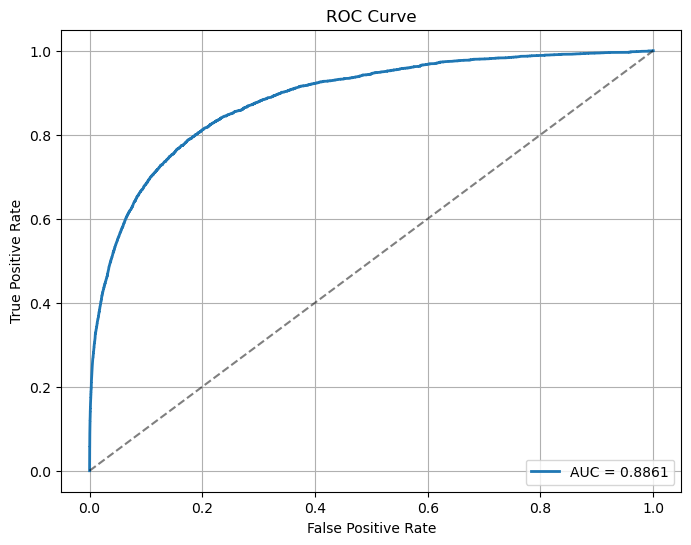

 AUC Score: 0.8861



In [14]:
from sklearn.metrics import roc_auc_score

# === 1. Check isFraud balance in train/val ===
def check_fraud_distribution(y_train, y_val):
    print(" Fraud distribution:")
    print(f"Train: {y_train.mean():.4f} ({y_train.sum()} frauds)")
    print(f"Val:   {y_val.mean():.4f} ({y_val.sum()} frauds)\n")

# === 2. Correlation with isFraud ===
def check_feature_correlation(df):
    print(" Top features highly correlated with isFraud:")
    corr = df.corr(numeric_only=True)['isFraud'].sort_values(key=abs, ascending=False)
    print(corr.head(10), "\n")

# === 3. Random prediction baseline ===
def check_random_auc(y_val):
    random_preds = np.random.rand(len(y_val))
    auc_random = roc_auc_score(y_val, random_preds)
    print(f" Random Model AUC (baseline): {auc_random:.4f}\n")

# === 4. Minimal feature model ===
def check_baseline_model(X_train, y_train, X_val, y_val):
    baseline_cols = [col for col in ['TransactionAmt', 'card1', 'card2', 'addr1'] if col in X_train.columns]
    if not baseline_cols:
        print(" Baseline features not in data.")
        return
    print(f" Re-training with weak features only: {baseline_cols}\n")
    X_base_train = X_train[baseline_cols]
    X_base_val = X_val[baseline_cols]
    
    model = train_lightgbm(X_base_train, y_train, X_base_val, y_val)
    plot_roc_auc(model, X_base_val, y_val)

# === Run All Checks ===
def run_sanity_checks(train_df, X_train, y_train, X_val, y_val):
    check_fraud_distribution(y_train, y_val)
    check_feature_correlation(train_df)
    check_random_auc(y_val)
    check_baseline_model(X_train, y_train, X_val, y_val)

# === Execute ===
run_sanity_checks(train_cleaned, X_train, y_train, X_val, y_val)


In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [16]:
# If not installed
# !pip install xgboost

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt


In [17]:
# Drop object columns (XGBoost can't handle categoricals directly)
def prepare_xgb_data(X):
    X = X.copy()
    X = X.select_dtypes(include=[np.number])
    return X.fillna(-999)  # Safe placeholder for missing values

X_train_xgb = prepare_xgb_data(X)
y_train_xgb = y.copy()


In [18]:
def xgb_cross_validation(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    print(f" Starting {n_splits}-fold cross-validation...\n")

    for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            learning_rate=0.05,
            n_estimators=200,         # keep fixed to avoid early stopping
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            tree_method='hist'
        )

        # Set eval_metric via internal param update
        model.set_params(eval_metric='auc')

        model.fit(X_tr, y_tr)

        y_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
        aucs.append(auc)

        fpr, tpr, _ = roc_curve(y_val, y_proba)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

        print(f"Fold {i+1} AUC: {auc:.4f}")

    print(f"\n Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    return aucs, mean_fpr, tprs


In [19]:
def plot_avg_roc_cv(mean_fpr, tprs):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label="Mean ROC (CV)", color='b')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Mean ROC Curve from XGBoost Cross-Validation")
    plt.legend()
    plt.grid(True)
    plt.show()


 Starting 5-fold cross-validation...



c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:25:27] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.9181


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:25:39] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.9182


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:25:49] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.9138


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:00] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.9163


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:12] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 AUC: 0.9156

 Mean AUC: 0.9164 ± 0.0017


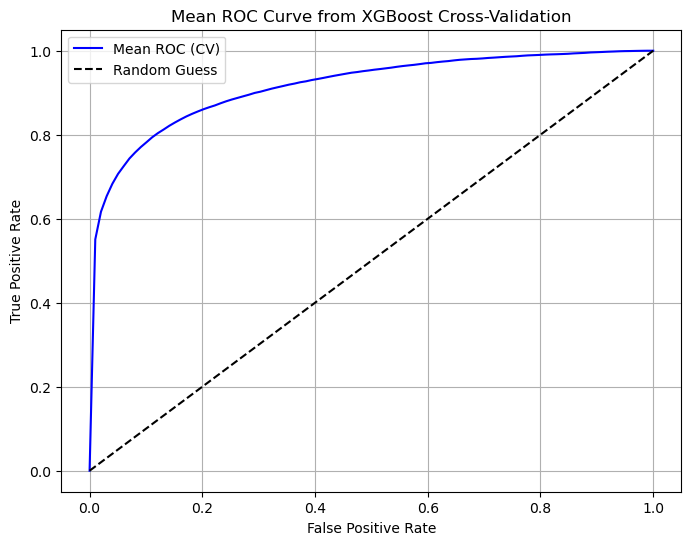

In [20]:
aucs, mean_fpr, tprs = xgb_cross_validation(X_train_xgb, y_train_xgb, n_splits=5)
plot_avg_roc_cv(mean_fpr, tprs)


In [21]:
# Use only numeric columns (same as XGBoost) and fill missing values
def prepare_lgbm_numeric(X):
    X = X.copy()
    X = X.select_dtypes(include=[np.number])
    return X.fillna(-999)  # Optional: LGBM can handle NaNs too

X_train_lgbm_restricted = prepare_lgbm_numeric(X_train)
X_val_lgbm_restricted = prepare_lgbm_numeric(X_val)


 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.940043	val's auc: 0.927257
[200]	train's auc: 0.959355	val's auc: 0.939965
[300]	train's auc: 0.969209	val's auc: 0.946119
[400]	train's auc: 0.975353	val's auc: 0.950113
[500]	train's auc: 0.980406	val's auc: 0.952932
[600]	train's auc: 0.98419	val's auc: 0.955006
[700]	train's auc: 0.986812	val's auc: 0.956876
[800]	train's auc: 0.988959	val's auc: 0.958323
[900]	train's auc: 0.990786	val's auc: 0.959373
[1000]	train's auc: 0.992452	val's auc: 0.960562
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.992452	val's auc: 0.960562
 Model training complete.

 Generating ROC curve...


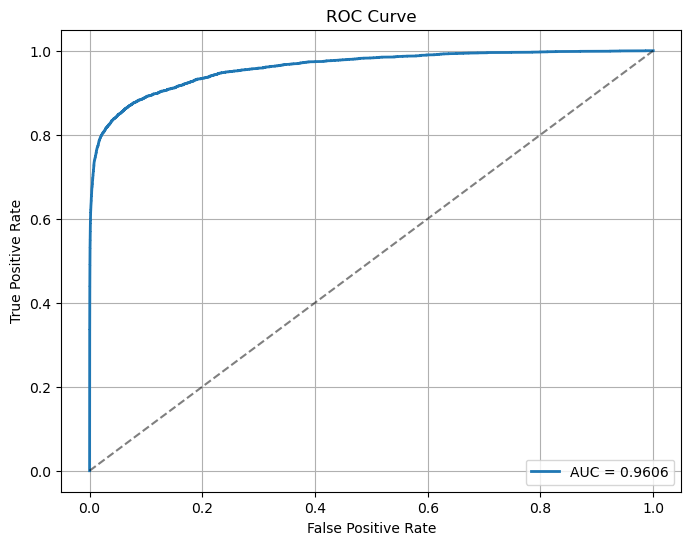

 AUC Score: 0.9606



In [22]:
# Use the same LightGBM training function you already have
lgb_model_restricted = train_lightgbm(
    X_train_lgbm_restricted,
    y_train,
    X_val_lgbm_restricted,
    y_val
)

# Plot ROC and print AUC
plot_roc_auc(lgb_model_restricted, X_val_lgbm_restricted, y_val)


In [23]:
from sklearn.preprocessing import OrdinalEncoder

# === Fit encoder on training data ===
def encode_full_dataset_fit(X):
    X = X.copy()

    # Force all categorical columns to string first
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X[cat_cols] = X[cat_cols].astype(str)

    # Encode categorical features
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    # Ensure all columns are float
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    return X.fillna(-999), encoder

# === Transform val/test data with fitted encoder ===
def encode_full_dataset_transform(X, encoder):
    X = X.copy()

    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X[cat_cols] = X[cat_cols].astype(str)
    X[cat_cols] = encoder.transform(X[cat_cols])

    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    return X.fillna(-999)


In [24]:
X_train_encoded, encoder = encode_full_dataset_fit(X_train)
X_val_encoded = encode_full_dataset_transform(X_val, encoder)


In [25]:
def train_xgboost_full(X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        tree_method='hist'
    )

    model.set_params(eval_metric='auc')  # for older XGBoost versions
    model.fit(X_train, y_train)
    
    return model


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:24] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


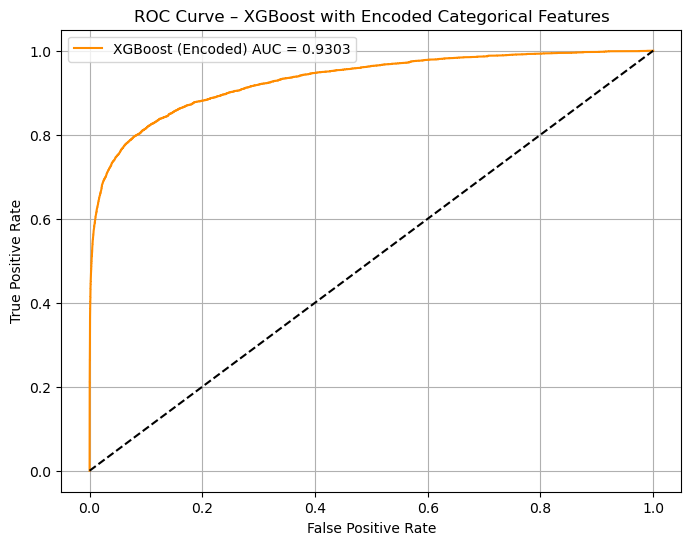

 AUC Score with Encoded XGBoost: 0.9303


In [26]:
xgb_model_encoded = train_xgboost_full(X_train_encoded, y_train, X_val_encoded, y_val)

# Evaluate
y_proba = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (Encoded) AUC = {auc_score:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost with Encoded Categorical Features")
plt.legend()
plt.grid(True)
plt.show()

print(f" AUC Score with Encoded XGBoost: {auc_score:.4f}")


In [27]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Minimal retraining setup
lgbm_sklearn_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=1000,
    random_state=42
)

lgbm_sklearn_model.fit(
    X_train_lgbm_restricted, y_train,
    eval_set=[(X_val_lgbm_restricted, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(50),
        log_evaluation(100)
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.927257	valid_0's binary_logloss: 0.0781338
[200]	valid_0's auc: 0.939965	valid_0's binary_logloss: 0.0709625
[300]	valid_0's auc: 0.946119	valid_0's binary_logloss: 0.0670823
[400]	valid_0's auc: 0.950113	valid_0's binary_logloss: 0.0643222
[500]	valid_0's auc: 0.952932	valid_0's binary_logloss: 0.0622877
[600]	valid_0's auc: 0.955006	valid_0's binary_logloss: 0.0607042
[700]	valid_0's auc: 0.956876	valid_0's binary_logloss: 0.0592727
[800]	valid_0's auc: 0.958323	valid_0's binary_logloss: 0.0581524
[900]	valid_0's auc: 0.959373	valid_0's binary_logloss: 0.0571869
[1000]	valid_0's auc: 0.960562	valid_0's binary_logloss: 0.0561995
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.960562	valid_0's binary_logloss: 0.0561995


LGBMClassifier(learning_rate=0.05, n_estimators=1000, num_leaves=64,
               objective='binary', random_state=42)

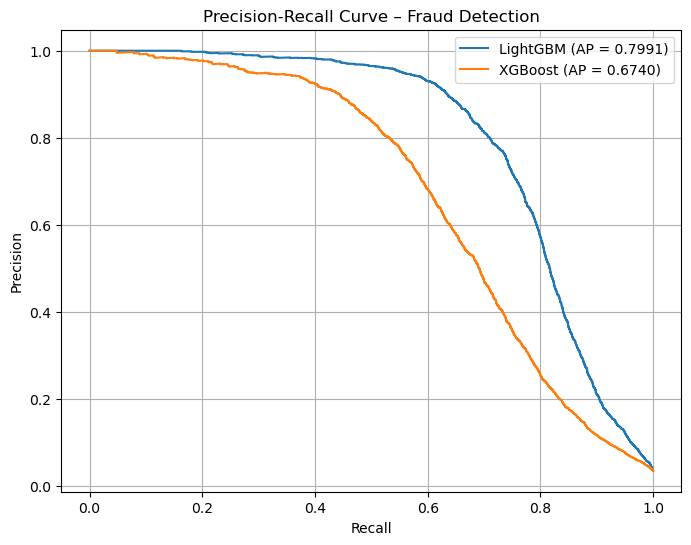

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Predict probabilities ===
y_proba_lgb = lgbm_sklearn_model.predict_proba(X_val_lgbm_restricted)[:, 1]
y_proba_xgb = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]

# === Compute PR curves ===
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_proba_xgb)
# === Compute AUCs ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)

# === Plot PR curves ===
plt.figure(figsize=(8, 6))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {ap_xgb:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Fraud Detection")
plt.grid(True)
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import (
    f1_score, fbeta_score, classification_report,
    balanced_accuracy_score, confusion_matrix
)

# === Threshold for classification (you can tune this later)
threshold = 0.5

# === Convert probabilities to binary predictions
y_pred_lgb = (y_proba_lgb >= threshold).astype(int)
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

# === F1 and Fβ scores
f1_lgb = f1_score(y_val, y_pred_lgb)
f1_xgb = f1_score(y_val, y_pred_xgb)

fbeta_lgb = fbeta_score(y_val, y_pred_lgb, beta=2)
fbeta_xgb = fbeta_score(y_val, y_pred_xgb, beta=2)

# === Balanced Accuracy
bal_acc_lgb = balanced_accuracy_score(y_val, y_pred_lgb)
bal_acc_xgb = balanced_accuracy_score(y_val, y_pred_xgb)

# === Scikit-learn Reports
print(" LightGBM Classification Report:\n")
print(classification_report(y_val, y_pred_lgb, digits=4))

print(" XGBoost Classification Report:\n")
print(classification_report(y_val, y_pred_xgb, digits=4))

# === Summary Output
print("\n Summary Metrics:")

print(f"LightGBM")
print(f"  F1 Score          : {f1_lgb:.4f}")
print(f"  F2 Score (β=2)    : {fbeta_lgb:.4f}")
print(f"  Balanced Accuracy : {bal_acc_lgb:.4f}")

print(f"\n XGBoost")
print(f"  F1 Score          : {f1_xgb:.4f}")
print(f"  F2 Score (β=2)    : {fbeta_xgb:.4f}")
print(f"  Balanced Accuracy : {bal_acc_xgb:.4f}")


 LightGBM Classification Report:

              precision    recall  f1-score   support

           0     0.9845    0.9988    0.9916    113975
           1     0.9467    0.5676    0.7097      4133

    accuracy                         0.9838    118108
   macro avg     0.9656    0.7832    0.8507    118108
weighted avg     0.9832    0.9838    0.9818    118108

 XGBoost Classification Report:

              precision    recall  f1-score   support

           0     0.9798    0.9984    0.9890    113975
           1     0.9069    0.4336    0.5867      4133

    accuracy                         0.9786    118108
   macro avg     0.9434    0.7160    0.7879    118108
weighted avg     0.9773    0.9786    0.9749    118108


 Summary Metrics:
LightGBM
  F1 Score          : 0.7097
  F2 Score (β=2)    : 0.6170
  Balanced Accuracy : 0.7832

 XGBoost
  F1 Score          : 0.5867
  F2 Score (β=2)    : 0.4841
  Balanced Accuracy : 0.7160


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


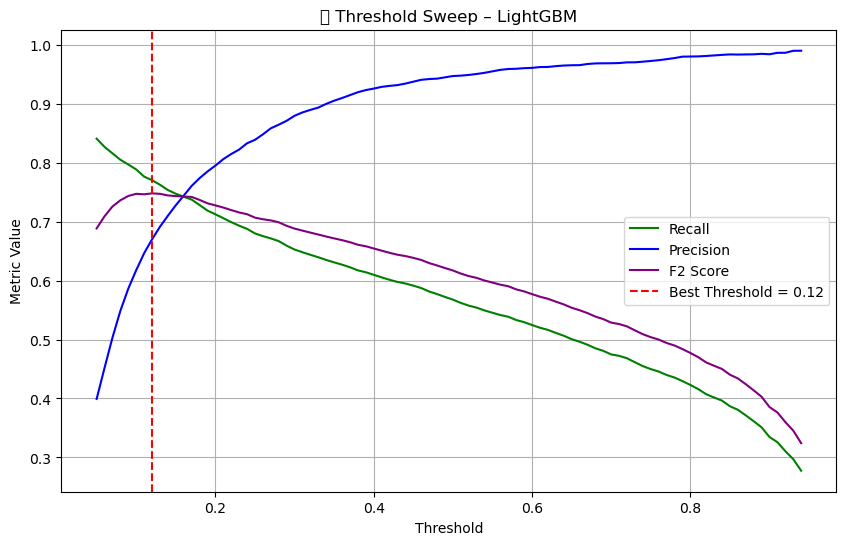

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, fbeta_score

thresholds = np.arange(0.05, 0.95, 0.01)
precisions = []
recalls = []
f2_scores = []

best_thresh = 0
best_f2 = 0

for t in thresholds:
    preds = (y_proba_lgb >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    f2 = fbeta_score(y_val, preds, beta=2)
    
    precisions.append(p)
    recalls.append(r)
    f2_scores.append(f2)
    
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, f2_scores, label="F2 Score", color="purple")
plt.axvline(x=best_thresh, linestyle="--", color="red", label=f"Best Threshold = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("🔍 Threshold Sweep – LightGBM")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
from sklearn.metrics import classification_report

# Default threshold (0.5)
preds_default = (y_proba_lgb >= 0.5).astype(int)
recall_default = recall_score(y_val, preds_default)

# Best threshold
preds_best = (y_proba_lgb >= best_thresh).astype(int)
recall_best = recall_score(y_val, preds_best)

print(f" Default Threshold (0.5) Recall      : {recall_default:.4f}")
print(f" Best Threshold ({best_thresh:.2f}) Recall : {recall_best:.4f}")
print(f" F2 Score at Best Threshold          : {best_f2:.4f}")

print("\n Classification Report at Best Threshold:\n")
print(classification_report(y_val, preds_best, digits=4))


 Default Threshold (0.5) Recall      : 0.5676
 Best Threshold (0.12) Recall : 0.7701
 F2 Score at Best Threshold          : 0.7477

 Classification Report at Best Threshold:

              precision    recall  f1-score   support

           0     0.9916    0.9862    0.9889    113975
           1     0.6698    0.7701    0.7165      4133

    accuracy                         0.9787    118108
   macro avg     0.8307    0.8782    0.8527    118108
weighted avg     0.9804    0.9787    0.9794    118108



In [32]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

# AUC and AUPRC (threshold-independent)
auc_lgb = roc_auc_score(y_val, y_proba_lgb)
auprc_lgb = average_precision_score(y_val, y_proba_lgb)

# Threshold-based predictions (you already chose 0.12)
threshold = 0.12
y_pred_thresh = (y_proba_lgb >= threshold).astype(int)

# Confusion matrix at threshold
cm = confusion_matrix(y_val, y_pred_thresh)

print(f" LightGBM Performance Summary (Threshold = {threshold:.2f})")
print(f"AUC       : {auc_lgb:.4f}")
print(f"AUPRC     : {auprc_lgb:.4f}")
print(f"Recall    : {recall_score(y_val, y_pred_thresh):.4f}")
print(f"Precision : {precision_score(y_val, y_pred_thresh):.4f}")
print(f"F1 Score  : {f1_score(y_val, y_pred_thresh):.4f}")
print(f"F2 Score  : {fbeta_score(y_val, y_pred_thresh, beta=2):.4f}")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_val, y_pred_thresh):.4f}")

print("\n Confusion Matrix:")
print(cm)


 LightGBM Performance Summary (Threshold = 0.12)
AUC       : 0.9606
AUPRC     : 0.7991
Recall    : 0.7701
Precision : 0.6698
F1 Score  : 0.7165
F2 Score  : 0.7477
Balanced Accuracy : 0.8782

 Confusion Matrix:
[[112406   1569]
 [   950   3183]]


In [33]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [34]:
def prepare_for_catboost(X):
    X = X.copy()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    # Replace NaNs with string 'missing' for object-type columns
    for col in cat_cols:
        X[col] = X[col].astype(str).fillna("missing")

    return X, cat_cols.tolist()


In [35]:
X_train_cb, cat_features_cb = prepare_for_catboost(X_train)
X_val_cb, _ = prepare_for_catboost(X_val)


In [36]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(X_train_cb, label=y_train, cat_features=cat_features_cb)
val_pool = Pool(X_val_cb, label=y_val, cat_features=cat_features_cb)

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

cat_model.fit(train_pool, eval_set=val_pool)


0:	test: 0.7074286	best: 0.7074286 (0)	total: 1.23s	remaining: 20m 25s
100:	test: 0.8796530	best: 0.8796530 (100)	total: 1m 33s	remaining: 13m 52s
200:	test: 0.8943424	best: 0.8943424 (200)	total: 3m 5s	remaining: 12m 19s
300:	test: 0.9020362	best: 0.9020362 (300)	total: 4m 36s	remaining: 10m 41s
400:	test: 0.9079134	best: 0.9079134 (400)	total: 6m 5s	remaining: 9m 6s
500:	test: 0.9118588	best: 0.9118588 (500)	total: 7m 37s	remaining: 7m 35s
600:	test: 0.9153798	best: 0.9153798 (600)	total: 9m 6s	remaining: 6m 2s
700:	test: 0.9181342	best: 0.9181342 (700)	total: 10m 33s	remaining: 4m 30s
800:	test: 0.9204654	best: 0.9204654 (800)	total: 12m 1s	remaining: 2m 59s
900:	test: 0.9225044	best: 0.9225044 (900)	total: 13m 39s	remaining: 1m 30s
999:	test: 0.9242489	best: 0.9242489 (999)	total: 15m 14s	remaining: 0us

bestTest = 0.9242488645
bestIteration = 999



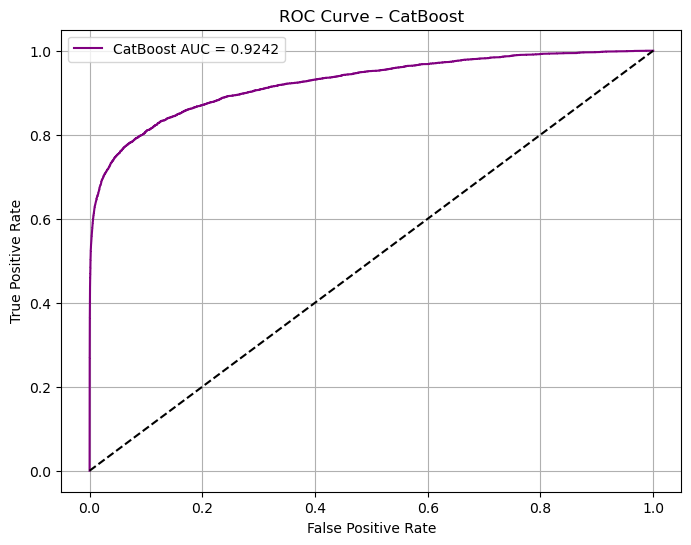

 Final CatBoost AUC: 0.9242


In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba_cb = cat_model.predict_proba(X_val_cb)[:, 1]
fpr_cb, tpr_cb, _ = roc_curve(y_val, y_proba_cb)
auc_cb = roc_auc_score(y_val, y_proba_cb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, label=f"CatBoost AUC = {auc_cb:.4f}", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CatBoost")
plt.legend()
plt.grid(True)
plt.show()

print(f" Final CatBoost AUC: {auc_cb:.4f}")


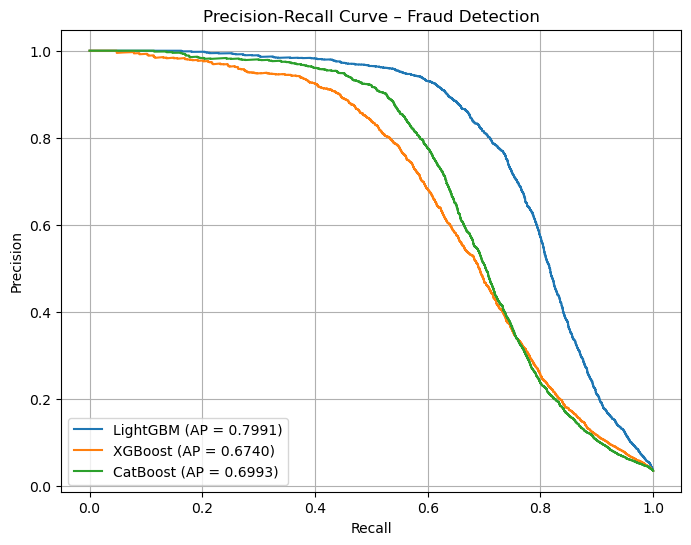

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Predict probabilities ===
y_proba_lgb = lgbm_sklearn_model.predict_proba(X_val_lgbm_restricted)[:, 1]
y_proba_xgb = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]
y_proba_cat = cat_model.predict_proba(X_val_cb)[:, 1]

# === Compute PR curves ===
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_proba_xgb)
precision_cat, recall_cat, _ = precision_recall_curve(y_val, y_proba_cat)

# === Compute AUCs ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)
ap_cat = average_precision_score(y_val, y_proba_cat)

# === Plot PR curves ===
plt.figure(figsize=(8, 6))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {ap_xgb:.4f})")
plt.plot(recall_cat, precision_cat, label=f"CatBoost (AP = {ap_cat:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Fraud Detection")
plt.grid(True)
plt.legend()
plt.show()


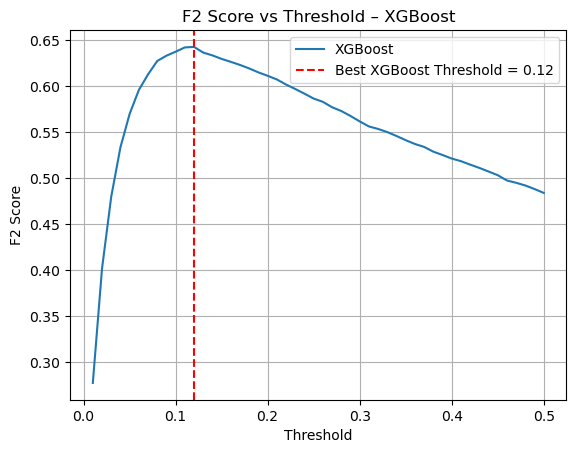

 XGBoost Best Threshold = 0.12
 F2 Score = 0.6426
 Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0     0.9882    0.9782    0.9832    113975
           1     0.5299    0.6787    0.5952      4133

    accuracy                         0.9677    118108
   macro avg     0.7591    0.8284    0.7892    118108
weighted avg     0.9722    0.9677    0.9696    118108



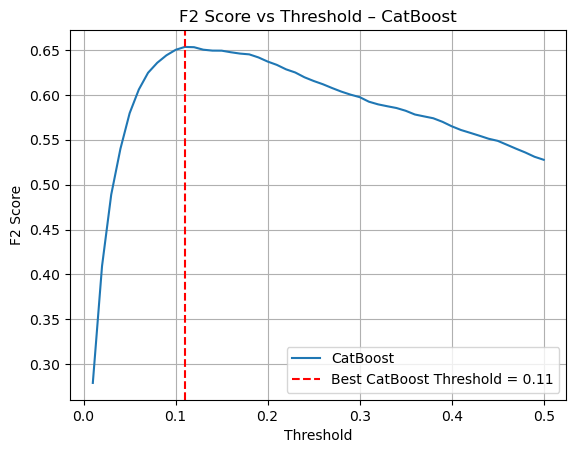

 CatBoost Best Threshold = 0.11
 F2 Score = 0.6535
 Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0     0.9887    0.9783    0.9834    113975
           1     0.5356    0.6915    0.6037      4133

    accuracy                         0.9682    118108
   macro avg     0.7622    0.8349    0.7936    118108
weighted avg     0.9728    0.9682    0.9702    118108



In [39]:
from sklearn.metrics import fbeta_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

def find_best_threshold(y_true, y_proba, model_name="Model"):
    thresholds = np.linspace(0.01, 0.5, 50)
    f2_scores = []

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        f2 = fbeta_score(y_true, preds, beta=2)
        f2_scores.append(f2)

    # Best threshold
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]

    # Plot F2 vs Threshold
    plt.plot(thresholds, f2_scores, label=model_name)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best {model_name} Threshold = {best_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("F2 Score")
    plt.title(f"F2 Score vs Threshold – {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Classification report at best threshold
    preds_best = (y_proba >= best_threshold).astype(int)
    report = classification_report(y_true, preds_best, digits=4)

    print(f" {model_name} Best Threshold = {best_threshold:.2f}")
    print(f" F2 Score = {best_f2:.4f}")
    print(f" Classification Report at Best Threshold:\n{report}")

    return best_threshold, best_f2

# === Run for XGBoost and CatBoost ===
best_thresh_xgb, best_f2_xgb = find_best_threshold(y_val, y_proba_xgb, model_name="XGBoost")
best_thresh_cat, best_f2_cat = find_best_threshold(y_val, y_proba_cat, model_name="CatBoost")


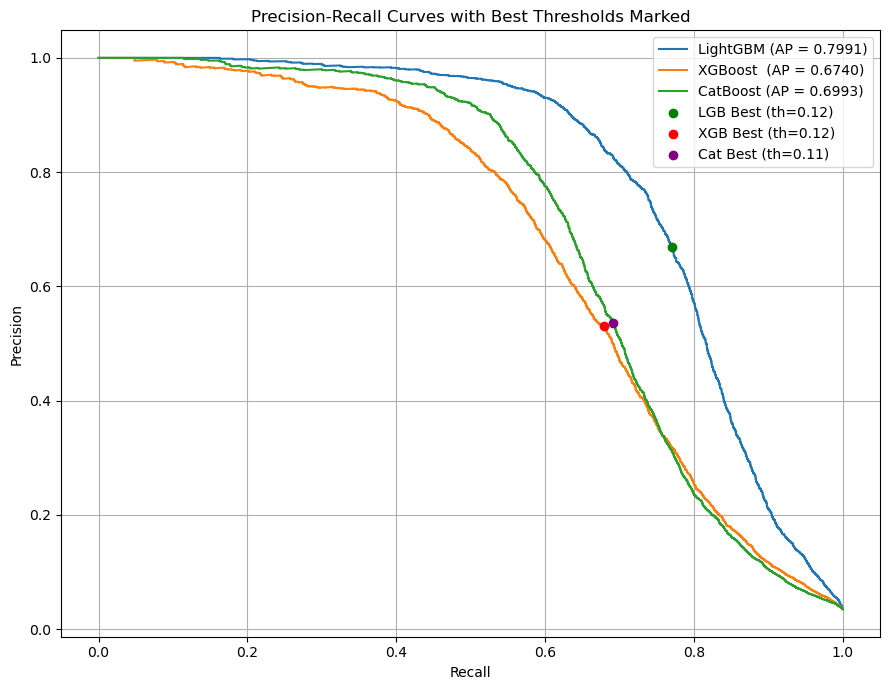

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Recompute precision and recall points ===
precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val, y_proba_xgb)
precision_cat, recall_cat, thresholds_cat = precision_recall_curve(y_val, y_proba_cat)

# === Compute AUPRC ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)
ap_cat = average_precision_score(y_val, y_proba_cat)

# === Find the closest recall/precision pair to the best threshold ===
def get_precision_recall_at_threshold(thresholds, precision, recall, best_thresh):
    idx = np.argmin(np.abs(thresholds - best_thresh))
    return precision[idx], recall[idx]

# For LightGBM
best_thresh_lgb = 0.12
p_lgb_best, r_lgb_best = get_precision_recall_at_threshold(thresholds_lgb, precision_lgb[:-1], recall_lgb[:-1], best_thresh_lgb)

# For XGBoost and CatBoost 
p_xgb_best, r_xgb_best = get_precision_recall_at_threshold(thresholds_xgb, precision_xgb[:-1], recall_xgb[:-1], best_thresh_xgb)
p_cat_best, r_cat_best = get_precision_recall_at_threshold(thresholds_cat, precision_cat[:-1], recall_cat[:-1], best_thresh_cat)

# === Plot Precision-Recall curves ===
plt.figure(figsize=(9, 7))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost  (AP = {ap_xgb:.4f})")
plt.plot(recall_cat, precision_cat, label=f"CatBoost (AP = {ap_cat:.4f})")

# Mark best threshold points
plt.scatter(r_lgb_best, p_lgb_best, color='green', label=f"LGB Best (th={best_thresh_lgb:.2f})", zorder=5)
plt.scatter(r_xgb_best, p_xgb_best, color='red', label=f"XGB Best (th={best_thresh_xgb:.2f})", zorder=5)
plt.scatter(r_cat_best, p_cat_best, color='purple', label=f"Cat Best (th={best_thresh_cat:.2f})", zorder=5)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Best Thresholds Marked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


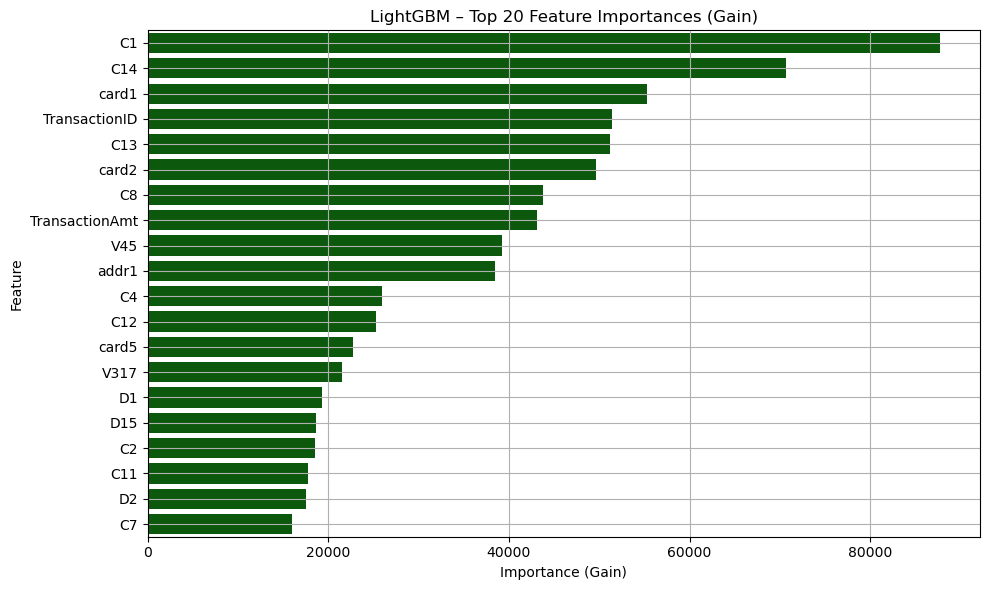

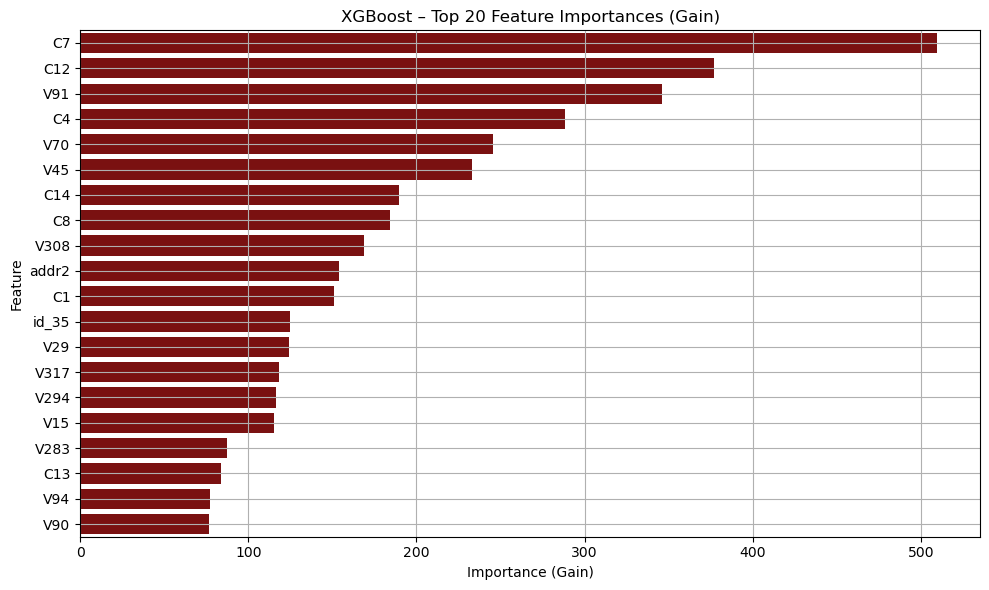

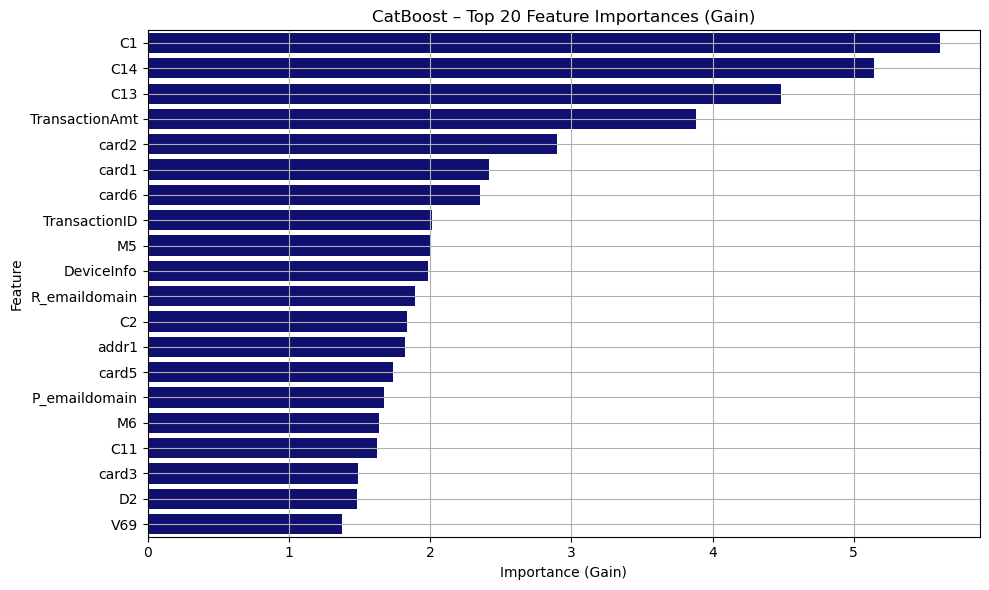

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# === Helper function ===
def plot_importances(importance_df, model_name, top_n=20, color='steelblue'):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importance_df.sort_values('importance', ascending=False).head(top_n),
        x='importance', y='feature', color=color
    )
    plt.title(f"{model_name} – Top {top_n} Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === LightGBM ===
lgb_importances = pd.DataFrame({
    'feature': X_train_lgbm_restricted.columns,
    'importance': lgbm_sklearn_model.booster_.feature_importance(importance_type='gain')
})
plot_importances(lgb_importances, "LightGBM", color='darkgreen')

# === XGBoost ===
xgb_scores = xgb_model_encoded.get_booster().get_score(importance_type='gain')
xgb_importances = pd.DataFrame({
    'feature': list(xgb_scores.keys()),
    'importance': list(xgb_scores.values())
})
plot_importances(xgb_importances, "XGBoost", color='darkred')

# === CatBoost ===
cb_importances = pd.DataFrame({
    'feature': X_val_cb.columns,
    'importance': cat_model.get_feature_importance(type='PredictionValuesChange')
})
plot_importances(cb_importances, "CatBoost", color='navy')


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.958775	valid_0's binary_logloss: 0.0567702
 AUC:           0.9588
 AUPRC:        0.7989
 Best Threshold: 0.1333
 F2 Score:      0.7508
 Recall:        0.7706
 Precision:     0.6808


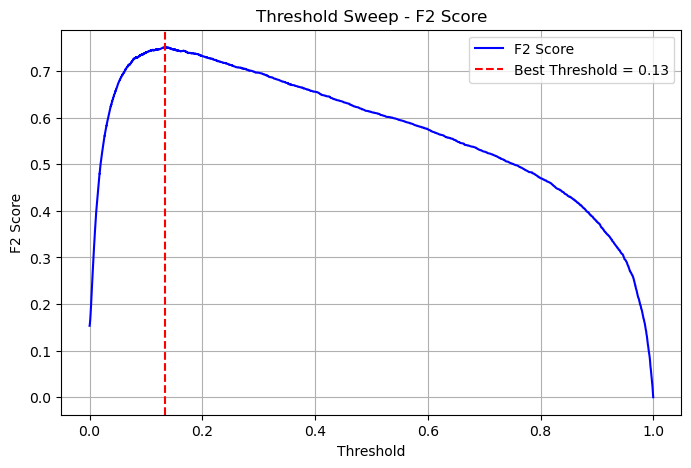

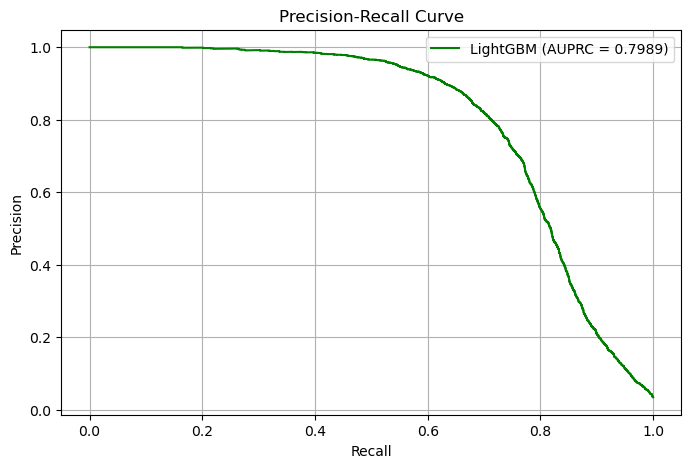

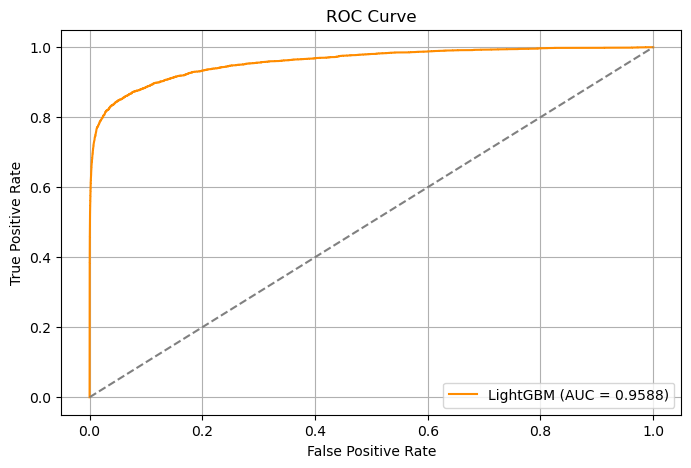

<Figure size 1000x800 with 0 Axes>

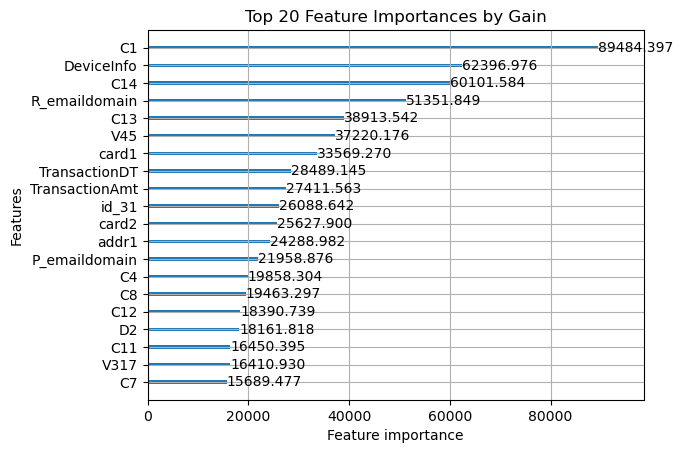

In [47]:
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, fbeta_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 1. Drop TransactionID from features ===
X_train_lgbm = X_train.drop(columns=['TransactionID'])
X_val_lgbm = X_val.drop(columns=['TransactionID'])

# === 2. Train LightGBM ===
lgbm_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=1000,
    random_state=42
)

lgbm_model.fit(
    X_train_lgbm, y_train,
    eval_set=[(X_val_lgbm, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50)]
)

# === 3. Predict Probabilities ===
y_proba = lgbm_model.predict_proba(X_val_lgbm)[:, 1]

# === 4. Metrics ===
auc_score = roc_auc_score(y_val, y_proba)
auprc_score = average_precision_score(y_val, y_proba)

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
f2_scores = 5 * (precision * recall) / (4 * precision + recall + 1e-8)
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

print(f" AUC:           {auc_score:.4f}")
print(f" AUPRC:        {auprc_score:.4f}")
print(f" Best Threshold: {best_threshold:.4f}")
print(f" F2 Score:      {f2_scores[best_idx]:.4f}")
print(f" Recall:        {recall[best_idx]:.4f}")
print(f" Precision:     {precision[best_idx]:.4f}")

# === 5. Plot: Threshold vs F2 ===
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f2_scores[:-1], label="F2 Score", color='blue')
plt.axvline(best_threshold, linestyle='--', color='red', label=f"Best Threshold = {best_threshold:.2f}")
plt.title("Threshold Sweep - F2 Score")
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.legend()
plt.grid(True)
plt.show()

# === 6. Plot: Precision-Recall Curve ===
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"LightGBM (AUPRC = {auprc_score:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import roc_curve

# === Compute ROC curve ===
fpr, tpr, _ = roc_curve(y_val, y_proba)

# === Plot ROC curve ===
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {auc_score:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


# === 7. Plot: Feature Importance ===
plt.figure(figsize=(10, 8))
plot_importance(lgbm_model, max_num_features=20, importance_type='gain', title="Top 20 Feature Importances by Gain")
plt.grid(True)
plt.show()
